Example on how to use the code to locally denoise.

# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
parent_dir = Path.cwd()
sys.path.append(str(parent_dir))
# Import modules
from sine_funcs import analyze_fft_results, create_phase_dataset
from denoise_funcs import denoise_samples, multi_trajectory_animation, Local_Sine_Wave_Denoiser

# Set device (automatically detects GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data and Noise Generation

In [2]:
# Dataset generation
num_points = 100 #points in a sample
points_per_cycle = 20
phases = [0]#, math.pi]#/4, math.pi/2, 3*math.pi/4]  # Example phase offsets
dataset = create_phase_dataset(phases, num_points, points_per_cycle, device = device)

# Load our dataset into an instance of local_sine_wave
local_denoiser_dataset = Local_Sine_Wave_Denoiser(dataset, sigma_i = 1.0, device = device)

In [3]:
# Noise Parameters
num_noise_samples = 50  # Number of different noise samples to process
noise_samples = torch.randn(size=(num_noise_samples, num_points), device=device)

In [4]:
# Denoising Parameters
num_steps = 10         # Number of denoising steps
dt = 1.0 / num_steps
local_size = 5

# Shape: [num_noise_samples, num_steps+1, num_points]
locality_sizes = torch.full((num_steps,), local_size, device=device) #for each step, use a local window of 100 points.

## Denoising

In [5]:
trajectories = denoise_samples(
    noise_samples=noise_samples,
    local_denoiser_dataset=local_denoiser_dataset,
    num_steps=10,
    locality_sizes=locality_sizes,  # Constant window size
    dt=dt,
    device='cuda'
)

Completed denoising for sample 1/50
Completed denoising for sample 11/50
Completed denoising for sample 21/50
Completed denoising for sample 31/50
Completed denoising for sample 41/50


In [6]:
anim = multi_trajectory_animation(trajectories, dataset=dataset)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(anim.to_jshtml())

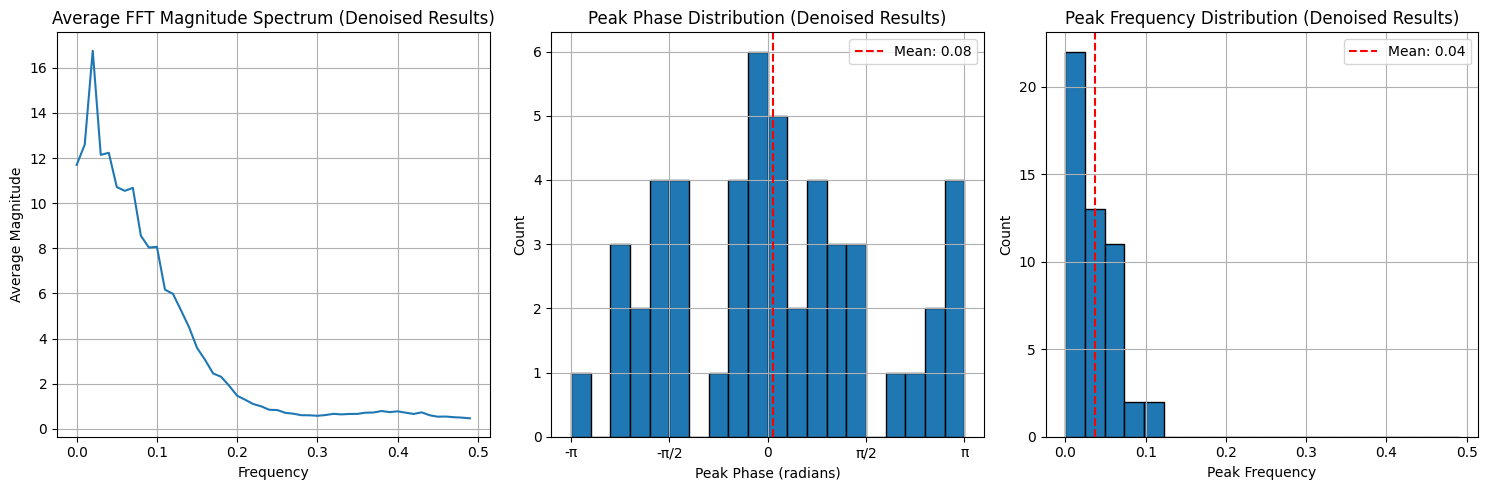


FFT Analysis Summary (50 samples):
Average peak phase: 0.082 ± 1.602 rad
Average peak frequency: 0.036 ± 0.024


In [7]:
analyze_fft_results(trajectories[:, -1, :], title_suffix="(Denoised Results)")